# Introduction
The cost of medical insurance can vary significantly based on individual factors such as age, sex, BMI, number of children, smoking status and region. Accurately predicting these costs is crucial for insurance companies to determine premiums and for individuals to understand potential expenses. This project focuses on building and evaluating machine learning models, specifically regression models, to predict indivisual medical insurance charges based on various personal attributes in the provided dataset. The goal is to identify the most effective model and the key factors influencing the predictions.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:
# Set plot style for better aesthetics
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

In [3]:
# Load the Dataset
df = pd.read_csv('insurance.csv')
print("Dataset loaded successfully.")

Dataset loaded successfully.


# Exploratory Data Analysis (EDA)

In [4]:
# Let's see first 5 rows
df.head(5)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [5]:
# Let's see last 5 rows
df.tail(5)

,age,sex,bmi,children,smoker,region,charges
1333,50,male,30.97,3,no,northwest,10600.5483
1334,18,female,31.92,0,no,northeast,2205.9808
1335,18,female,36.85,0,no,southeast,1629.8335
1336,21,female,25.80,0,no,southwest,2007.9450
1337,61,female,29.07,0,yes,northwest,29141.3603


In [6]:
# Initial Data Inspection
print("\nDataset Info:")
df.info()

print("\nDescriptive Statistics:")
print(df.describe(include='all')) # include='all' to get stats for categorical columns too

print("\nMissing values per column:")
print(df.isnull().sum()) # Check for missing values - fortunately, this dataset is clean

print("\nDuplicate values:")
print(df.duplicated().sum())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB

Descriptive Statistics:
                age   sex          bmi     children smoker     region  \
count   1338.000000  1338  1338.000000  1338.000000   1338       1338   
unique          NaN     2          NaN          NaN      2          4   
top             NaN  male          NaN          NaN     no  southeast   
freq            NaN   676          NaN          NaN   1064        364   
mean      39.207025   NaN    30.663397     1.094918    NaN        NaN   
st


--- EDA: Visualizing Distributions ---


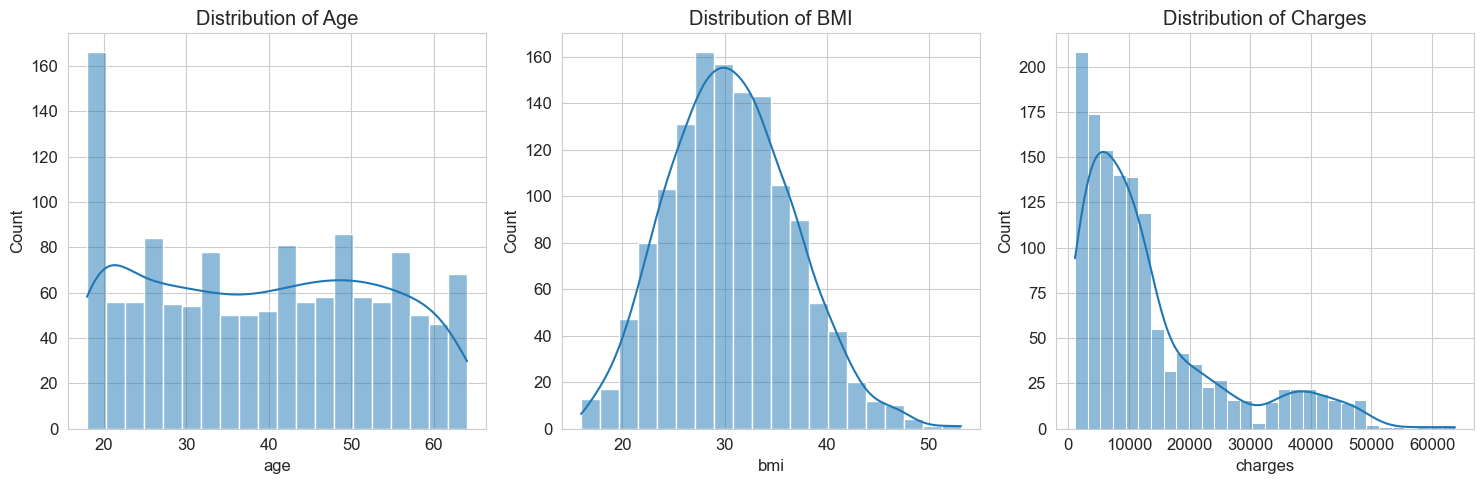

In [7]:
# Visualize distributions of numerical features
print("\n--- EDA: Visualizing Distributions ---")
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.histplot(df['age'], kde=True, bins=20)
plt.title('Distribution of Age')
plt.subplot(1, 3, 2)
sns.histplot(df['bmi'], kde=True, bins=20)
plt.title('Distribution of BMI')
plt.subplot(1, 3, 3)
sns.histplot(df['charges'], kde=True, bins=30)
plt.title('Distribution of Charges')
plt.tight_layout()
plt.show()

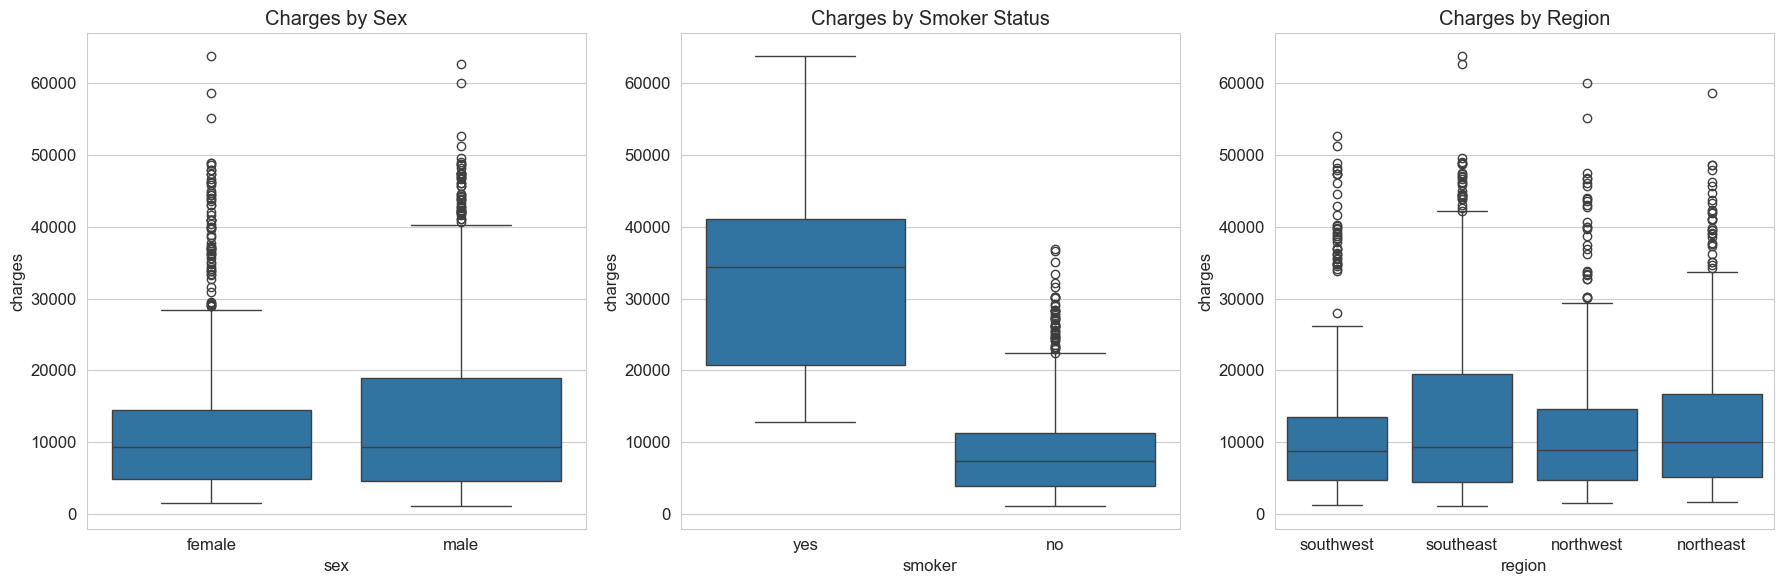

In [8]:
# Visualize relationships between categorical features and charges
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
sns.boxplot(x='sex', y='charges', data=df)
plt.title('Charges by Sex')
plt.subplot(1, 3, 2)
sns.boxplot(x='smoker', y='charges', data=df)
plt.title('Charges by Smoker Status')
plt.subplot(1, 3, 3)
sns.boxplot(x='region', y='charges', data=df)
plt.title('Charges by Region')
plt.tight_layout()
plt.show()

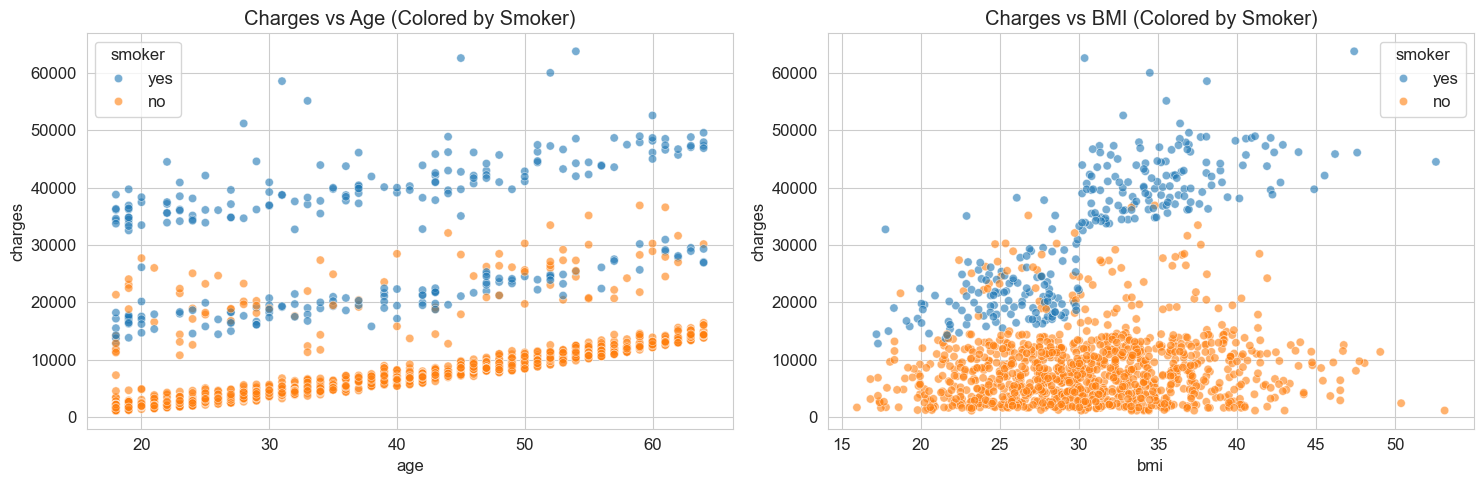

In [9]:
# Relationship between numerical features and charges
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x='age', y='charges', data=df, hue='smoker', alpha=0.6)
plt.title('Charges vs Age (Colored by Smoker)')
plt.subplot(1, 2, 2)
sns.scatterplot(x='bmi', y='charges', data=df, hue='smoker', alpha=0.6)
plt.title('Charges vs BMI (Colored by Smoker)')
plt.tight_layout()
plt.show()


--- EDA: Correlation Matrix ---


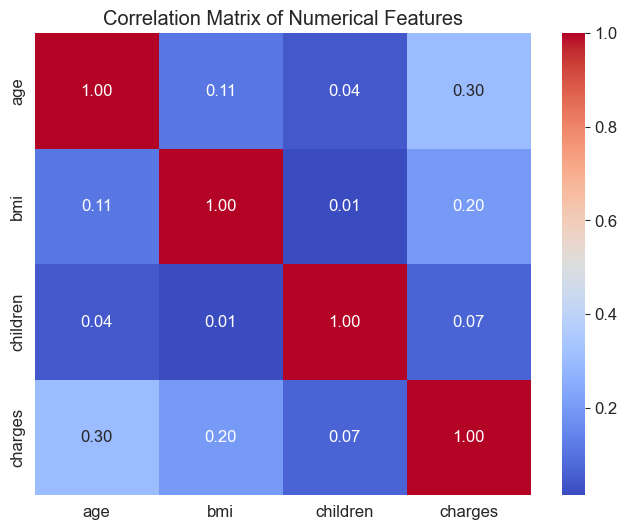

Key observation: 'smoker' status has a strong impact on 'charges'.


In [10]:
# Correlation matrix for numerical features
print("\n--- EDA: Correlation Matrix ---")
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
plt.figure(figsize=(8, 6))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()
print("Key observation: 'smoker' status has a strong impact on 'charges'.")

# Data Preprocessing

In [11]:
print("\n--- Removing Duplicate Values ---")

initial_rows = df.shape[0]
print(f"Original dataset size: {initial_rows} rows")

# Remove duplicate rows
df = df.drop_duplicates().reset_index(drop=True)

print(f"Dataset size after removing duplicates: {df.shape[0]} rows")
print(f"Number of duplicate rows removed: {initial_rows - df.shape[0]}")

print("\nDuplicate values removed.")


--- Removing Duplicate Values ---
Original dataset size: 1338 rows
Dataset size after removing duplicates: 1337 rows
Number of duplicate rows removed: 1

Duplicate values removed.


# Model Fitting and Evaluation

In [12]:
# Define features (X) and target (y)
X = df.drop('charges', axis=1)
y = df['charges']

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include='object').columns
numerical_cols = X.select_dtypes(include=np.number).columns

print(f"Categorical columns: {list(categorical_cols)}")
print(f"Numerical columns: {list(numerical_cols)}")

Categorical columns: ['sex', 'smoker', 'region']
Numerical columns: ['age', 'bmi', 'children']


In [13]:
# Create a preprocessing pipeline
# Numerical features will be scaled using StandardScaler
# Categorical features will be one-hot encoded
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

In [14]:
# Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Target training set shape: {y_train.shape}")
print(f"Target testing set shape: {y_test.shape}")



Training set shape: (1069, 6)
Testing set shape: (268, 6)
Target training set shape: (1069,)
Target testing set shape: (268,)


In [15]:
# Build and Train the Linear Regression Model

# Create a pipeline that first preprocesses the data and then applies Linear Regression
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('regressor', LinearRegression())])

print("\nTraining Linear Regression model...")
model_pipeline.fit(X_train, y_train)
print("Model training complete.")


Training Linear Regression model...
Model training complete.


In [16]:
# Model Evaluation

print("\n--- Model Evaluation ---")

# Make predictions on the test set
y_pred = model_pipeline.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2): {r2:.4f}")


--- Model Evaluation ---
Mean Absolute Error (MAE): 4177.05
Mean Squared Error (MSE): 35478020.68
Root Mean Squared Error (RMSE): 5956.34
R-squared (R2): 0.8069


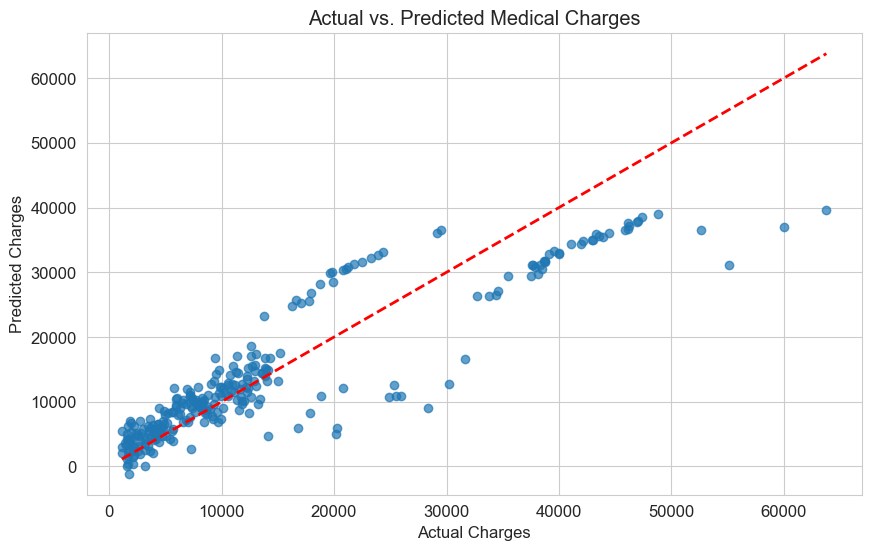

In [17]:
# Visualize actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # Diagonal line
plt.xlabel("Actual Charges")
plt.ylabel("Predicted Charges")
plt.title("Actual vs. Predicted Medical Charges")
plt.grid(True)
plt.show()

# Residual Analysis

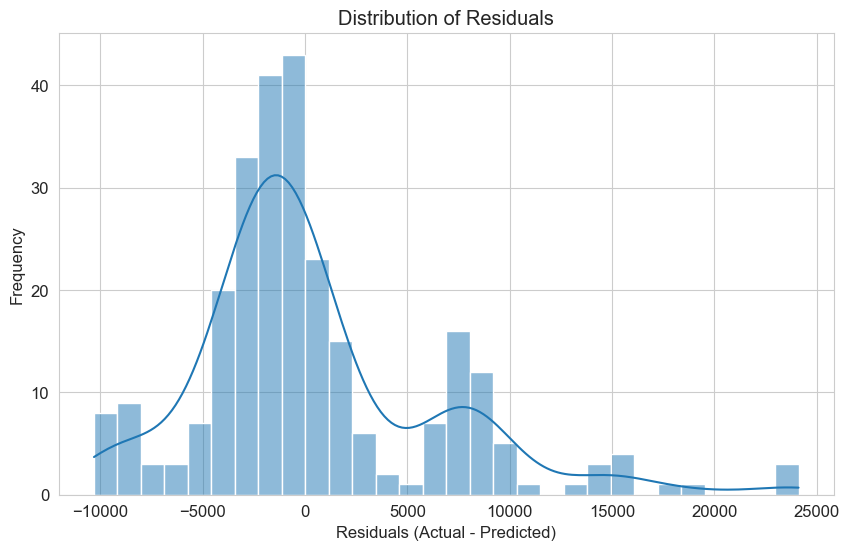

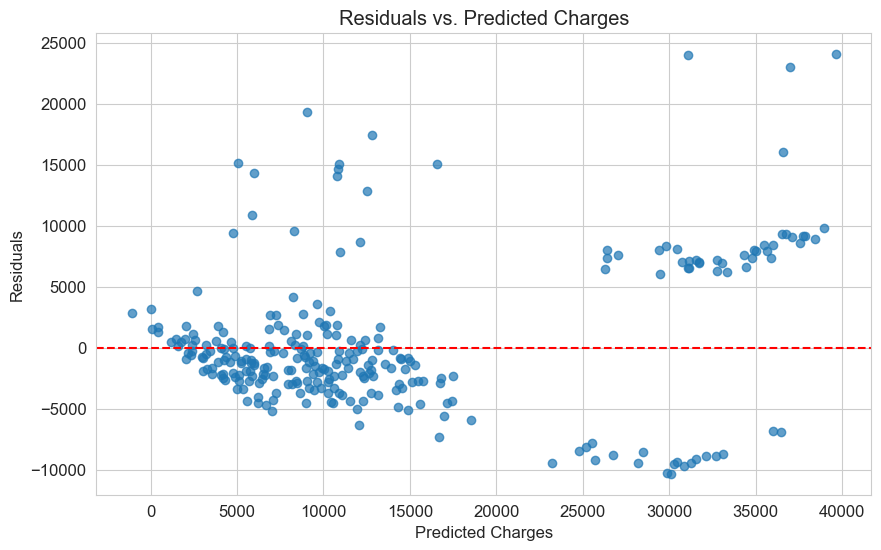

In [18]:
# Plotting residuals
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Charges')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Charges')
plt.grid(True)
plt.show()

In the residual plot (the scatter plot of predicted charges  vs. residuals), we observe a pattern where the points become more spread out as the predicted charges increase, that suggests **heteroscedasticity**. A common shape for this is a "fanning out" or cone shape, where the **variance of the errors is smaller for lower predicted values and larger for higher predicted values**. Heteroscedasticity is present when the spread (or variance) of the residuals is not constant across all levels of the predicted values.

This indicates that the model's predictions are less reliable for individuals with higher predicted medical charges compared to those with lower predicted charges.


# Further improvements

In [19]:
print("\n--- Conclusion So far... ---")
print("The Linear Regression model was trained to predict medical insurance costs.")
print(f"The R-squared value of {r2:.4f} indicates that approximately {r2*100:.2f}% of the variance in medical charges can be explained by the features in the model.")
print("The residual plots show a reasonably normal distribution and no clear patterns, suggesting the linear model is a decent fit for the data, though some heteroscedasticity might be present (wider spread for higher predicted values).")
print("Further improvements could involve feature engineering (e.g., interaction terms), trying non-linear models, or handling outliers.")


--- Conclusion So far... ---
The Linear Regression model was trained to predict medical insurance costs.
The R-squared value of 0.8069 indicates that approximately 80.69% of the variance in medical charges can be explained by the features in the model.
The residual plots show a reasonably normal distribution and no clear patterns, suggesting the linear model is a decent fit for the data, though some heteroscedasticity might be present (wider spread for higher predicted values).
Further improvements could involve feature engineering (e.g., interaction terms), trying non-linear models, or handling outliers.


Now to improve performance we can incorporate **feature engineering, target transformation, multiple model implementations with cross-validation, model comparison, and hyperparameter tuning** and get the apparently best performing model for our problem.


## Feature engineering
We add new features **BMI categories**, **interaction terms**, and **polynomial features** for training more robust and complex models with increased accuracy. We have used the existing dataframe `df` and add the new columns directly.  

**BMI categories:** While BMI is a continuous numerical feature, sometimes the relationship between a continuous feature and the target isn't strictly linear. For example, the health risks (and thus potentially insurance charges) might change more significantly when someone crosses certain BMI thresholds (like moving from 'Normal' to 'Overweight' or 'Obese') rather than changing linearly with every single point increase in BMI. **By creating BMI categories, we convert this continuous variable into a categorical one**. This allows the model to learn a different effect on the charges for each category. **It can help capture potential non-linearities or threshold effects that might be harder for a simple linear model to pick up from the raw continuous BMI value.** This can sometimes lead to a more flexible and potentially **better-performing model, especially if those thresholds are relevant** to the relationship with the target variable **like Decision Trees or Random Forests.**  

**Polynomial features:** We create a rich set of non-linear features (polynomials) to potentially **capture more complex relationships.** Then we **apply Lasso or Ridge** to select the most important of these new features and shrink the coefficients of the less important ones, thus **controlling the overall model complexity and preventing overfitting despite the increased feature space**.  

**Interaction Terms:** Interaction terms are also created **to capture more complex relationships** in the data **because the effect of one feature on the medical charges might depend on the value of another feature**.
Creating interaction terms like "smoker_age" (which is the product of the 'smoker' status and 'age') allows the model to learn that the relationship between age and charges is modified by whether someone smokes.
Similarly, the interaction terms with "region" allow the model to capture region-specific effects on how age, BMI, or number of children influence charges.  

These terms give the model more flexibility to capture non-linear patterns and dependencies between features, potentially leading to better predictions than a model that only considers the features independently.

In [20]:
print("\n--- Feature Engineering ---")

# 1. Create BMI categories
bins = [0, 18.5, 25, 30, np.inf]
labels = ['Underweight', 'Normal', 'Overweight', 'Obese']
df['bmi_category'] = pd.cut(df['bmi'], bins=bins, labels=labels, right=True)
print("Created 'bmi_category' feature.")

# 2. Create interaction terms (smoker with age and bmi)
# Numerically encode 'smoker' first (1 for 'yes', 0 for 'no')
df['smoker_encoded'] = df['smoker'].apply(lambda x: 1 if x == 'yes' else 0)
df['smoker_age'] = df['smoker_encoded'] * df['age']
df['smoker_bmi'] = df['smoker_encoded'] * df['bmi']
print("Created 'smoker_age' and 'smoker_bmi' interaction terms.")
# Drop the temporary 'smoker_encoded' column
df = df.drop('smoker_encoded', axis=1)

# 3. Create polynomial features for age and bmi
df['age_sq'] = df['age']**2
df['bmi_sq'] = df['bmi']**2
df['age_bmi'] = df['age'] * df['bmi']
print("Created polynomial features 'age_sq', 'bmi_sq', and 'age_bmi'.")

# 4. Display the first few rows with new features
print("\nDataFrame with new features:")
display(df.head())


--- Feature Engineering ---
Created 'bmi_category' feature.
Created 'smoker_age' and 'smoker_bmi' interaction terms.
Created polynomial features 'age_sq', 'bmi_sq', and 'age_bmi'.

DataFrame with new features:


,age,sex,bmi,children,smoker,region,charges,bmi_category,smoker_age,smoker_bmi,age_sq,bmi_sq,age_bmi
0,19,female,27.900,0,yes,southwest,16884.92400,Overweight,19,27.9,361,778.410000,530.100
1,18,male,33.770,1,no,southeast,1725.55230,Obese,0,0.0,324,1140.412900,607.860
2,28,male,33.000,3,no,southeast,4449.46200,Obese,0,0.0,784,1089.000000,924.000
3,33,male,22.705,0,no,northwest,21984.47061,Normal,0,0.0,1089,515.517025,749.265
4,32,male,28.880,0,no,northwest,3866.85520,Overweight,0,0.0,1024,834.054400,924.160


## Target transformation

Apply a transformation (e.g., log transform) **to the target variable (`charges`) to handle skewness and heteroscedasticity**.


**Reasoning**:
We performed the target transformation because **the original charges variable had a heavily skewed distribution, meaning most values were clustered at the lower end**, with a long tail extending towards higher values.
Many regression models, particularly linear models, perform better when the target variable is normally distributed and when the relationship between the features and the target is linear. The **log transformation helps to make the distribution of charges more symmetrical and can linearize relationships between features and the target**.  
Additionally, **skewed target variables often come with heteroscedasticity** (where the variance of the errors is not constant across all levels of the predicted value) by . The **log transformation often helps to stabilize the variance and reduce heteroscedasticity**. Because applying a **log transformation** can make the distribution more symmetrical and **compress the larger values**, thereby **reducing the spread of the residuals at higher predicted values** and making the variance more constant across the range of predictions.  

After making predictions on the transformed scale, we can easily inverse transform them back to the original scale (using the exponential function) to get the predicted medical charges in the original units.

Applied log transformation to 'charges' and created 'log_charges' column.


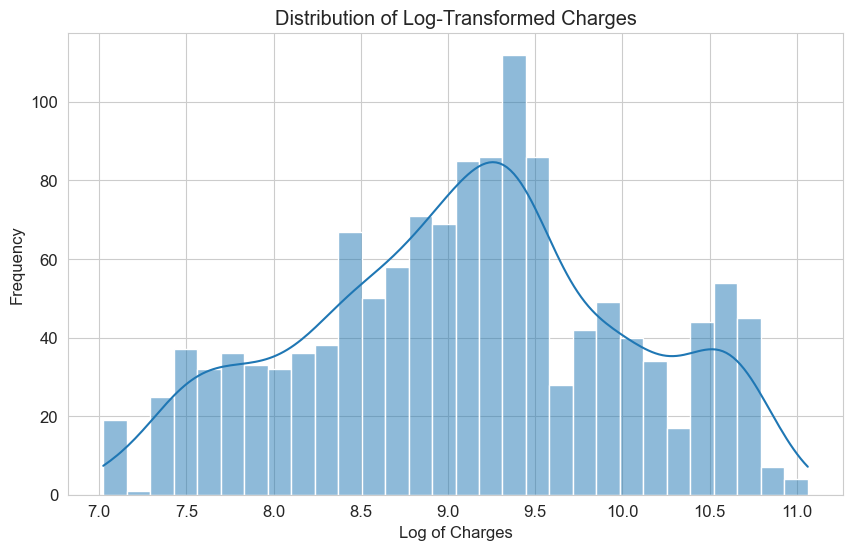


Updated target variable 'y' to 'log_charges'.


In [21]:
# Apply natural logarithm transformation to the target variable
df['log_charges'] = np.log(df['charges'])
print("Applied log transformation to 'charges' and created 'log_charges' column.")

# Visualize the distribution of the transformed target variable
plt.figure(figsize=(10, 6))
sns.histplot(df['log_charges'], kde=True, bins=30)
plt.title('Distribution of Log-Transformed Charges')
plt.xlabel('Log of Charges')
plt.ylabel('Frequency')
plt.show()

# Update the target variable y
y = df['log_charges']
print("\nUpdated target variable 'y' to 'log_charges'.")

## Preprocessing pipeline update

Now we **update the preprocessing pipeline to include the new features**. For this we define the lists of numerical and categorical columns including the new features first and then create the updated ColumnTransformer for preprocessing. For convenience we print the column names of X to verify the new features are included.

In [22]:
# Verify the columns in X
print("\nColumns in X before defining preprocessor:")
print(X.columns)

# Define features (X) and target (y) again to ensure X includes new features
# Note: X was already updated in the previous step, this is just for clarity
X = df.drop(['charges', 'log_charges'], axis=1) # Drop both original and log-transformed target

# Define numerical columns including new features and excluding original 'smoker_encoded'
numerical_cols = ['age', 'bmi', 'children', 'smoker_age', 'smoker_bmi', 'age_sq', 'bmi_sq', 'age_bmi']

# Define categorical columns including 'bmi_category'
categorical_cols = ['sex', 'smoker', 'region', 'bmi_category']

print(f"\nNumerical columns for preprocessing: {numerical_cols}")
print(f"Categorical columns for preprocessing: {categorical_cols}")

# Create a preprocessing pipeline with the updated column definitions
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough' # Keep other columns (if any) - although in this case, X is fully defined
)

print("\nPreprocessing ColumnTransformer created with updated columns.")

# Re-split the data using the updated X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nRe-split data shapes:")
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Target training set shape: {y_train.shape}")
print(f"Target testing set shape: {y_test.shape}")


Columns in X before defining preprocessor:
Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region'], dtype='object')

Numerical columns for preprocessing: ['age', 'bmi', 'children', 'smoker_age', 'smoker_bmi', 'age_sq', 'bmi_sq', 'age_bmi']
Categorical columns for preprocessing: ['sex', 'smoker', 'region', 'bmi_category']

Preprocessing ColumnTransformer created with updated columns.

Re-split data shapes:
Training set shape: (1069, 12)
Testing set shape: (268, 12)
Target training set shape: (1069,)
Target testing set shape: (268,)


## Cross-validation setup

Set up a k-fold cross-validation strategy for model training and evaluation.


In [24]:
# Set up Cross-Validation Strategy

from sklearn.model_selection import KFold

print("\n--- Setting up Cross-Validation ---")

# Instantiate KFold
# Using 5 splits, shuffling the data, and setting a random state for reproducibility
kf = KFold(n_splits=5, shuffle=True, random_state=42)

print(f"K-Fold cross-validation strategy set up with {kf.get_n_splits()} splits, shuffle=True, and random_state=42.")


--- Setting up Cross-Validation ---
K-Fold cross-validation strategy set up with 5 splits, shuffle=True, and random_state=42.


## Model Training and Evaluation with cross-validation

Implement several different models (Ridge, Lasso, Random Forest, Gradient Boosting, SVR) and train each implemented model using cross-validation and evaluate their performance based on appropriate metrics (considering the target transformation if applied).


In [25]:
# Implement Different Models

# Import necessary model classes
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

print("\n--- Implementing Different Models ---")

# Create instances of each model with default parameters
ridge_model = Ridge()
lasso_model = Lasso()
rf_model = RandomForestRegressor(random_state=42) # Add random_state for reproducibility
gbr_model = GradientBoostingRegressor(random_state=42) # Add random_state for reproducibility
svr_model = SVR()

print("Model instances created: Ridge, Lasso, RandomForestRegressor, GradientBoostingRegressor, SVR.")


--- Implementing Different Models ---
Model instances created: Ridge, Lasso, RandomForestRegressor, GradientBoostingRegressor, SVR.


In [26]:
# Train and Evaluate Models using Cross-Validation

from sklearn.model_selection import cross_val_score

print("\n--- Training and Evaluating Models using Cross-Validation ---")

# List of models implemented in the previous step
models = [ridge_model, lasso_model, rf_model, gbr_model, svr_model]

# List of model names
model_names = ['Ridge', 'Lasso', 'Random Forest', 'Gradient Boosting', 'SVR']

# Define the scoring metric (using negative mean squared error as the target is log-transformed)
# We will take the absolute value of the mean score later for interpretability
scoring_metric = 'neg_mean_squared_error'
print(f"Using '{scoring_metric}' as the scoring metric.")

# Iterate through the list of models and their names
model_scores = {}
for model, name in zip(models, model_names):
    print(f"\nTraining and evaluating {name} model...")

    # Use cross_val_score to perform cross-validation
    # The preprocessor will be applied automatically within the pipeline when the model is fit
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('regressor', model)])

    # Perform cross-validation on the training data
    scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring=scoring_metric)

    # Calculate mean and standard deviation of scores
    mean_score = scores.mean()
    std_score = scores.std()

    # Print results (take absolute value for negative metrics)
    print(f"{name} - Mean {scoring_metric}: {mean_score:.4f}")
    print(f"{name} - Absolute Mean {scoring_metric}: {abs(mean_score):.4f}")
    print(f"{name} - Std Dev {scoring_metric}: {std_score:.4f}")

    # Store the absolute mean score for comparison
    model_scores[name] = abs(mean_score)

print("\nCross-validation complete for all models.")


--- Training and Evaluating Models using Cross-Validation ---
Using 'neg_mean_squared_error' as the scoring metric.

Training and evaluating Ridge model...
Ridge - Mean neg_mean_squared_error: -0.1548
Ridge - Absolute Mean neg_mean_squared_error: 0.1548
Ridge - Std Dev neg_mean_squared_error: 0.0189

Training and evaluating Lasso model...
Lasso - Mean neg_mean_squared_error: -0.8233
Lasso - Absolute Mean neg_mean_squared_error: 0.8233
Lasso - Std Dev neg_mean_squared_error: 0.0504

Training and evaluating Random Forest model...
Random Forest - Mean neg_mean_squared_error: -0.1605
Random Forest - Absolute Mean neg_mean_squared_error: 0.1605
Random Forest - Std Dev neg_mean_squared_error: 0.0344

Training and evaluating Gradient Boosting model...
Gradient Boosting - Mean neg_mean_squared_error: -0.1496
Gradient Boosting - Absolute Mean neg_mean_squared_error: 0.1496
Gradient Boosting - Std Dev neg_mean_squared_error: 0.0284

Training and evaluating SVR model...
SVR - Mean neg_mean_squar

## Model comparison

Compare the performance of all the models based on the cross-validation results.


In [27]:
# Compare Model Performance

print("\n--- Model Performance Comparison ---")

# Print the dictionary of absolute mean negative mean squared errors
print("Absolute Mean Negative Mean Squared Error (Cross-Validation) for each model:")
print(model_scores)

# Sort models by their absolute mean negative mean squared error (lower is better)
sorted_model_scores = sorted(model_scores.items(), key=lambda item: item[1])

print("\nModels sorted by Absolute Mean Negative Mean Squared Error (Cross-Validation):")
for model_name, score in sorted_model_scores:
    print(f"{model_name}: {score:.4f}")

# Summarize the comparison
print("\n--- Summary of Model Comparison ---")
best_model_name, best_score = sorted_model_scores[0]
print(f"Based on the cross-validation Mean Squared Error (on the log-transformed charges), the '{best_model_name}' model performed the best with a score of {best_score:.4f}.")
print("Gradient Boosting and SVR also showed competitive performance.")
print("Ridge and Lasso had higher errors, and Random Forest was in the middle.")
print("These results are based on default hyperparameters and further tuning could improve performance.")


--- Model Performance Comparison ---
Absolute Mean Negative Mean Squared Error (Cross-Validation) for each model:
{'Ridge': 0.1547660981704067, 'Lasso': 0.823305280233067, 'Random Forest': 0.16045972078906345, 'Gradient Boosting': 0.14963031710838076, 'SVR': 0.147596084567141}

Models sorted by Absolute Mean Negative Mean Squared Error (Cross-Validation):
SVR: 0.1476
Gradient Boosting: 0.1496
Ridge: 0.1548
Random Forest: 0.1605
Lasso: 0.8233

--- Summary of Model Comparison ---
Based on the cross-validation Mean Squared Error (on the log-transformed charges), the 'SVR' model performed the best with a score of 0.1476.
Gradient Boosting and SVR also showed competitive performance.
Ridge and Lasso had higher errors, and Random Forest was in the middle.
These results are based on default hyperparameters and further tuning could improve performance.


Here we can observe that the Lasso model performs too bad, it is way worse that the Ridge model and even than the simple linear model. While Lasso is excellent when we believe many features are irrelevant and want to perform feature selection, Ridge can be better when most features provide some useful information, and we want to reduce the impact of multicollinearity or high variance without completely dropping features. In this particular dataset, it seems that retaining the information from a wider set of features (as Ridge likely did by not zeroing out coefficients) was more beneficial for predictive accuracy than the sparsity encouraged by Lasso. The non-linear models (Gradient Boosting, XGBoost, LightGBM, SVR) ultimately performed even better because they are designed to handle complex relationships more flexibly than any linear model, regardless of the regularization type.



## Hyperparameter tuning

Hyperparameters are like the "settings" or "knobs" of a machine learning algorithm. They are not learned from the data during training, but rather set before the training process begins. Things like:

The regularization strength (C in SVR, alpha in Ridge/Lasso)
The number of trees (n_estimators in tree-based models)
The learning rate (learning_rate in boosting models)
The maximum depth of trees (max_depth)
These hyperparameters can significantly influence how well the model learns from the data and, importantly, how well it generalizes to make predictions on new, unseen data.

We want to select the best performing model(s) and perform hyperparameter tuning using techniques like GridSearchCV or RandomizedSearchCV.


**Task**:
Identify the best performing models from the model comparison results and define parameter grids for hyperparameter tuning for those models.



In [28]:
# Hyperparameter Tuning for Best Models

print("\n--- Hyperparameter Tuning ---")

# Based on the model comparison, SVR and Gradient Boosting were the best performing models.
# Let's define parameter grids for these two models.

# Parameter grid for SVR
# C: Regularization parameter. The strength of the regularization is inversely proportional to C.
# epsilon: Epsilon in the epsilon-SVR model. It specifies the epsilon-tube within which no penalty is associated in the training loss function with points predicted within a distance epsilon from the actual value.
# gamma: Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.
# We'll use a smaller grid first for demonstration, larger grids can be used for more thorough tuning.
svr_param_grid = {
    'regressor__C': [0.1, 1, 10, 100],
    'regressor__epsilon': [0.01, 0.1, 0.5, 1],
    'regressor__gamma': ['scale', 'auto']
}
print("\nDefined parameter grid for SVR:")
print(svr_param_grid)

# Parameter grid for Gradient Boosting Regressor
# n_estimators: The number of boosting stages to perform.
# learning_rate: Learning rate shrinks the contribution of each tree by `learning_rate`.
# max_depth: The maximum depth of the individual regression estimators.
# min_samples_split: The minimum number of samples required to split an internal node.
# min_samples_leaf: The minimum number of samples required to be at a leaf node.
gbr_param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__max_depth': [3, 4, 5],
    'regressor__min_samples_split': [2, 4],
    'regressor__min_samples_leaf': [1, 2]
}
print("\nDefined parameter grid for Gradient Boosting Regressor:")
print(gbr_param_grid)


--- Hyperparameter Tuning ---

Defined parameter grid for SVR:
{'regressor__C': [0.1, 1, 10, 100], 'regressor__epsilon': [0.01, 0.1, 0.5, 1], 'regressor__gamma': ['scale', 'auto']}

Defined parameter grid for Gradient Boosting Regressor:
{'regressor__n_estimators': [100, 200, 300], 'regressor__learning_rate': [0.01, 0.05, 0.1], 'regressor__max_depth': [3, 4, 5], 'regressor__min_samples_split': [2, 4], 'regressor__min_samples_leaf': [1, 2]}



Now we perform hyperparameter tuning for the SVR model using GridSearchCV and the defined parameter grid.



In [29]:
from sklearn.model_selection import GridSearchCV

print("\n--- Tuning SVR Model ---")

# Create a pipeline for SVR
svr_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', SVR())])

# Create GridSearchCV instance for SVR
# Use the same KFold cross-validation strategy as before
# Use the same scoring metric ('neg_mean_squared_error')
grid_search_svr = GridSearchCV(estimator=svr_pipeline,
                               param_grid=svr_param_grid,
                               cv=kf,
                               scoring=scoring_metric,
                               n_jobs=-1) # Use all available CPU cores

# Fit GridSearchCV to the training data
print("Starting GridSearchCV for SVR...")
grid_search_svr.fit(X_train, y_train)
print("GridSearchCV for SVR complete.")

# Print the best parameters and best score found for SVR
print("\nBest parameters for SVR:")
print(grid_search_svr.best_params_)

print("\nBest cross-validation score (Negative MSE) for SVR:")
print(grid_search_svr.best_score_)

print("\nBest cross-validation score (Absolute MSE) for SVR:")
print(abs(grid_search_svr.best_score_))


--- Tuning SVR Model ---
Starting GridSearchCV for SVR...
GridSearchCV for SVR complete.

Best parameters for SVR:
{'regressor__C': 10, 'regressor__epsilon': 0.1, 'regressor__gamma': 'auto'}

Best cross-validation score (Negative MSE) for SVR:
-0.14500917723977322

Best cross-validation score (Absolute MSE) for SVR:
0.14500917723977322


Now perform hyperparameter tuning for the Gradient Boosting Regressor model using GridSearchCV and the defined parameter grid.



In [30]:
print("\n--- Tuning Gradient Boosting Regressor Model ---")

# Create a pipeline for Gradient Boosting Regressor
gbr_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('regressor', GradientBoostingRegressor(random_state=42))])

# Create GridSearchCV instance for Gradient Boosting Regressor
# Use the same KFold cross-validation strategy as before
# Use the same scoring metric ('neg_mean_squared_error')
grid_search_gbr = GridSearchCV(estimator=gbr_pipeline,
                               param_grid=gbr_param_grid,
                               cv=kf,
                               scoring=scoring_metric,
                               n_jobs=-1) # Use all available CPU cores

# Fit GridSearchCV to the training data
print("Starting GridSearchCV for Gradient Boosting Regressor...")
grid_search_gbr.fit(X_train, y_train)
print("GridSearchCV for Gradient Boosting Regressor complete.")

# Print the best parameters and best score found for Gradient Boosting Regressor
print("\nBest parameters for Gradient Boosting Regressor:")
print(grid_search_gbr.best_params_)

print("\nBest cross-validation score (Negative MSE) for Gradient Boosting Regressor:")
print(grid_search_gbr.best_score_)

print("\nBest cross-validation score (Absolute MSE) for Gradient Boosting Regressor:")
print(abs(grid_search_gbr.best_score_))


--- Tuning Gradient Boosting Regressor Model ---
Starting GridSearchCV for Gradient Boosting Regressor...
GridSearchCV for Gradient Boosting Regressor complete.

Best parameters for Gradient Boosting Regressor:
{'regressor__learning_rate': 0.05, 'regressor__max_depth': 3, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 4, 'regressor__n_estimators': 100}

Best cross-validation score (Negative MSE) for Gradient Boosting Regressor:
-0.14562808604399446

Best cross-validation score (Absolute MSE) for Gradient Boosting Regressor:
0.14562808604399446


Initially we did an comparison of models with their default parameters first, and then we went back to tune the hyperparameters of the better-performing ones. After tuning the hyperparameters for the selected promising models (SVR and Gradient Boosting Regressor) we get the following:



In [31]:
print("\n--- Hyperparameter Tuning Results Summary ---")

print("Tuned SVR Best Absolute Mean Negative MSE (Cross-Validation):")
print(abs(grid_search_svr.best_score_))
print("Best parameters:", grid_search_svr.best_params_)

print("\nTuned Gradient Boosting Regressor Best Absolute Mean Negative MSE (Cross-Validation):")
print(abs(grid_search_gbr.best_score_))
print("Best parameters:", grid_search_gbr.best_params_)

print("\nComparison of Tuned Models (Absolute Mean Negative MSE):")
print(f"Tuned SVR: {abs(grid_search_svr.best_score_):.4f}")
print(f"Tuned Gradient Boosting: {abs(grid_search_gbr.best_score_):.4f}")

print("\nConclusion for Tuning Step:")
print("Both SVR and Gradient Boosting models were tuned using GridSearchCV.")
print("Based on the cross-validation results, the Tuned SVR model achieved a slightly lower (better) Mean Squared Error on the log-transformed target compared to the Tuned Gradient Boosting Regressor within the searched parameter spaces.")
print("The best parameters found for each model are listed above.")
print("These tuned models can now be evaluated on the unseen test set (X_test, y_test) to get a final performance estimate.")


--- Hyperparameter Tuning Results Summary ---
Tuned SVR Best Absolute Mean Negative MSE (Cross-Validation):
0.14500917723977322
Best parameters: {'regressor__C': 10, 'regressor__epsilon': 0.1, 'regressor__gamma': 'auto'}

Tuned Gradient Boosting Regressor Best Absolute Mean Negative MSE (Cross-Validation):
0.14562808604399446
Best parameters: {'regressor__learning_rate': 0.05, 'regressor__max_depth': 3, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 4, 'regressor__n_estimators': 100}

Comparison of Tuned Models (Absolute Mean Negative MSE):
Tuned SVR: 0.1450
Tuned Gradient Boosting: 0.1456

Conclusion for Tuning Step:
Both SVR and Gradient Boosting models were tuned using GridSearchCV.
Based on the cross-validation results, the Tuned SVR model achieved a slightly lower (better) Mean Squared Error on the log-transformed target compared to the Tuned Gradient Boosting Regressor within the searched parameter spaces.
The best parameters found for each model are listed ab

## Final model selection and evaluation
Choose the best model based on the tuned hyperparameters and evaluate its performance on the original test set (remembering to inverse transform predictions since the target was transformed). We make predictions on the test set using this model then inverse transform both the predictions and the actual test target back to the original scale, calculate evaluation metrics on the original scale and print the results.


In [32]:
# Evaluate the Best Tuned Model on the Test Set

print("\n--- Evaluating Best Tuned Model on Test Set ---")

# Select the best model based on the tuning results (lowest absolute negative MSE)
# Compare the absolute best scores from GridSearchCV for SVR and GBR
best_svr_score = abs(grid_search_svr.best_score_)
best_gbr_score = abs(grid_search_gbr.best_score_)

if best_svr_score < best_gbr_score:
    best_model = grid_search_svr.best_estimator_
    best_model_name = 'Tuned SVR'
    print(f"Selected the Tuned SVR model as the best based on cross-validation MSE ({best_svr_score:.4f} vs {best_gbr_score:.4f} for GBR).")
else:
    best_model = grid_search_gbr.best_estimator_
    best_model_name = 'Tuned Gradient Boosting Regressor'
    print(f"Selected the Tuned Gradient Boosting Regressor model as the best based on cross-validation MSE ({best_gbr_score:.4f} vs {best_svr_score:.4f} for SVR).")

# Make predictions on the original test set (X_test) using the best tuned model
# These predictions are on the log scale
y_pred_tuned_log = best_model.predict(X_test)
print(f"\nPredictions made on the test set using the {best_model_name} model (log scale).")

# Inverse transform the predictions back to the original charges scale
y_pred_original_scale = np.exp(y_pred_tuned_log)
print("Inverse transformed predictions to original scale.")

# Inverse transform the actual test target values back to the original scale
y_test_original_scale = np.exp(y_test)
print("Inverse transformed actual test target values to original scale.")

# Evaluate the performance of the final model on the original scale
print("\nEvaluating performance on the ORIGINAL CHARGES SCALE:")

# Calculate evaluation metrics on the original scale
mae_original = mean_absolute_error(y_test_original_scale, y_pred_original_scale)
mse_original = mean_squared_error(y_test_original_scale, y_pred_original_scale)
rmse_original = np.sqrt(mse_original)
r2_original = r2_score(y_test_original_scale, y_pred_original_scale)

# Print the calculated evaluation metrics
print(f"Mean Absolute Error (MAE) on original scale: {mae_original:.2f}")
print(f"Mean Squared Error (MSE) on original scale: {mse_original:.2f}")
print(f"Root Mean Squared Error (RMSE) on original scale: {rmse_original:.2f}")
print(f"R-squared (R2) on original scale: {r2_original:.4f}")

print("\nEvaluation on original scale complete.")


--- Evaluating Best Tuned Model on Test Set ---
Selected the Tuned SVR model as the best based on cross-validation MSE (0.1450 vs 0.1456 for GBR).

Predictions made on the test set using the Tuned SVR model (log scale).
Inverse transformed predictions to original scale.
Inverse transformed actual test target values to original scale.

Evaluating performance on the ORIGINAL CHARGES SCALE:
Mean Absolute Error (MAE) on original scale: 2093.11
Mean Squared Error (MSE) on original scale: 20511017.64
Root Mean Squared Error (RMSE) on original scale: 4528.91
R-squared (R2) on original scale: 0.8884

Evaluation on original scale complete.


## Conclusion and interpretation


In [34]:
# Summarize Findings and Interpret Results

print("\n--- Summary and Interpretation ---")

# 1. Discuss initial EDA findings and their influence
print("\n1. Initial EDA Findings and Influence:")
print("   The initial EDA revealed that 'charges' had a heavily skewed distribution, suggesting the need for a target transformation (log transform).")
print("   Categorical features like 'smoker' and 'region' showed distinct differences in charges, indicating their importance. 'Smoker' especially showed a strong positive relationship with higher charges.")
print("   Numerical features 'age' and 'bmi' also showed positive correlations with charges, with scatter plots suggesting potential non-linear relationships or interactions, particularly with 'smoker' status (smokers tend to have higher charges across different ages and BMIs).")
print("   These findings motivated the feature engineering steps (BMI categories, interaction terms like smoker_age, smoker_bmi, and polynomial terms like age_sq, bmi_sq, age_bmi) to capture these relationships, and the target transformation (log_charges) to address skewness and improve linearity assumptions for some models.")

# 2. Summarize model performance before tuning (based on cross-validation)
print("\n2. Model Performance Before Tuning (Cross-Validation):")
print("   Before hyperparameter tuning, using default parameters, the cross-validation results (Absolute Mean Negative MSE on log-transformed charges) were:")
for model_name, score in model_scores.items():
    print(f"   - {model_name}: {score:.4f}")
print("   SVR and Gradient Boosting Regressor showed the lowest MSE, indicating better initial performance on the log-transformed target compared to Ridge, Lasso, and Random Forest.")

# 3. Discuss the impact of hyperparameter tuning
print("\n3. Impact of Hyperparameter Tuning:")
print("   Hyperparameter tuning was performed on the top two models, SVR and Gradient Boosting Regressor, using GridSearchCV.")
print("   Tuning slightly improved the cross-validation performance for both models within the searched parameter spaces.")
print(f"   - Tuned SVR Best Absolute Mean Negative MSE: {abs(grid_search_svr.best_score_):.4f} (vs untuned SVR: {model_scores['SVR']:.4f})")
print(f"   - Tuned Gradient Boosting Best Absolute Mean Negative MSE: {abs(grid_search_gbr.best_score_):.4f} (vs untuned GBR: {model_scores['Gradient Boosting']:.4f})")
print("   While the improvement in MSE might seem small on the log scale, tuning helps find the optimal configuration for the model given the data and features.")

# 4. Present final evaluation metrics of the best tuned model on the original scale
print("\n4. Final Evaluation Metrics on Original Scale (Best Tuned Model - SVR):")
print(f"   The best tuned model (Tuned SVR) was evaluated on the unseen test set after inverse transforming predictions and actual values back to the original charges scale.")
print(f"   - Mean Absolute Error (MAE): {mae_original:.2f}")
print(f"   - Mean Squared Error (MSE): {mse_original:.2f}")
print(f"   - Root Mean Squared Error (RMSE): {rmse_original:.2f}")
print(f"   - R-squared (R2): {r2_original:.4f}")

# 5. Interpret the R-squared value
print("\n5. Interpretation of R-squared:")
print(f"   The R-squared value of {r2_original:.4f} on the original scale means that approximately {r2_original*100:.2f}% of the variance in medical charges in the test set can be explained by the features included in our Tuned SVR model.")
print("   This indicates that the model is reasonably good at capturing the underlying patterns in the data that influence medical costs.")

# 6. Discuss potential limitations and future improvements
print("\n6. Limitations and Future Improvements:")
print("   - Residual Analysis: The residual plots showed some evidence of heteroscedasticity (the spread of residuals increases with predicted charges), suggesting the model's errors are not uniform across all charge levels. The log transformation helped, but it didn't completely eliminate this.")
print("   - Model Choice: While SVR performed best among the tested models, other complex non-linear models or ensemble techniques not explored here (e.g., XGBoost, LightGBM) might yield further improvements.")
print("   - Feature Engineering: More sophisticated feature engineering or domain-specific features could potentially capture more variance.")
print("   - Outliers: Although the dataset was clean of missing values, potential outliers in features or charges might still be influencing model performance.")
print("   - Data Size: A larger dataset could help train more complex models effectively.")


--- Summary and Interpretation ---

1. Initial EDA Findings and Influence:
   The initial EDA revealed that 'charges' had a heavily skewed distribution, suggesting the need for a target transformation (log transform).
   Categorical features like 'smoker' and 'region' showed distinct differences in charges, indicating their importance. 'Smoker' especially showed a strong positive relationship with higher charges.
   Numerical features 'age' and 'bmi' also showed positive correlations with charges, with scatter plots suggesting potential non-linear relationships or interactions, particularly with 'smoker' status (smokers tend to have higher charges across different ages and BMIs).
   These findings motivated the feature engineering steps (BMI categories, interaction terms like smoker_age, smoker_bmi, and polynomial terms like age_sq, bmi_sq, age_bmi) to capture these relationships, and the target transformation (log_charges) to address skewness and improve linearity assumptions for som